In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size

# Steady one-dimensional flow in coastal aquifers

## Confined interface flow

<img src="figs/fig4.1.png" width=400>

In [2]:
# parameters
k = 10 # hydraulic conductivity, m/d
zt = -10 # top of aquifer, m
zb = -30 # bottom of aquifer, m
rhof = 1000 # density of fresh water, kg/m^3
rhos = 1025 # density of salt water, kg/m^3
U = 0.4 # flow towards the coast, m^2/d
H = zt - zb # aquifer thickness, m

In [3]:
# solution
alpha = rhof / (rhos - rhof)
phitoe = 0.5 * k * H ** 2 / alpha
Cc = (0.5 * k * H ** 2 + k * H * zb) / alpha
x = np.linspace(-200, 0, 150)
phi = -U * x
h = np.zeros_like(phi)
h[phi <= phitoe] = np.sqrt(2 * phi[phi <= phitoe] / (k * alpha)) - zt / alpha
h[phi > phitoe] = (phi[phi > phitoe] - Cc) / (k * H)
zi = np.maximum(-alpha * h, zb)
#
xtoe = -k * H**2 / (2 * alpha * U)
print(f'x-location of the toe: {xtoe:.0f} m')
# stream function
xg = [x, x]
zg = [zi, zt * np.ones(len(x))]
psi = [np.zeros(len(x)), -U * np.ones(len(x))]

x-location of the toe: -125 m


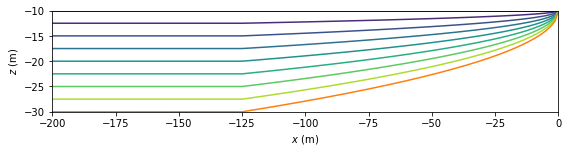

In [4]:
# basic streamline plot
plt.subplot(111, aspect=2)
plt.contour(xg, zg, psi)
plt.plot(x, zi, 'C1')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()

## Unconfined interface flow

<img src="figs/fig4.2.png" width=400>

In [5]:
# parameters
k = 40 # hydraulic conductivity, m/d
zb = -20 # bottom of aquifer, m
rhof = 1000 # density of fresh water, kg/m^3
rhos = 1025 # density of salt water, kg/m^3
L = 1000 # width of island, m
N1 = 0.001 # recharge rate 1, m/d
N2 = 0.002 # recharge rate 2, m/d
alpha = rhof / (rhos - rhof) # alpha factor

In [6]:
# solution
def pot(x, N, L):
    phi = -0.5 * N * (x**2 - L * x)
    return phi

def pot2h(pot, k, alpha, zb):
    phitoe = 0.5 * k * (alpha + 1) / alpha**2 * zb**2
    Cu = -0.5 * k * (alpha + 1) * zb**2 / alpha
    h = np.zeros(len(pot))
    h[pot < phitoe] = np.sqrt(2 * pot[pot < phitoe] / (k * (alpha + 1)))
    h[pot >= phitoe] = np.sqrt(2 * (pot[pot >= phitoe] - Cu) / k) + zb
    return h

def zinterface(h, alpha, zb):
    return np.maximum(-alpha * h, zb)

x = np.linspace(0, L, 201)
phi1 = pot(x, N1, L)
phi2 = pot(x, N2, L)
h1 = pot2h(phi1, k, alpha, zb)
h2 = pot2h(phi2, k, alpha, zb)
zi1 = zinterface(h1, alpha, zb)
zi2 = zinterface(h2, alpha, zb)

phitoe = 0.5 * k * (alpha + 1) / alpha**2 * zb**2
print(f'Phi_toe: {phitoe:.2f}')
print(f'N={N1} results in maximum phi {np.max(phi1)}')
print(f'N={N2} results in maximum phi {np.max(phi2)}')

Phi_toe: 205.00
N=0.001 results in maximum phi 125.0
N=0.002 results in maximum phi 250.0


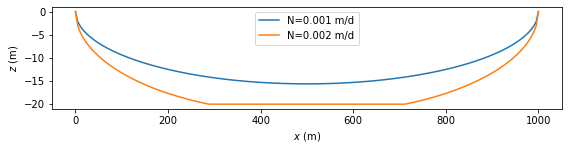

In [7]:
# basic plot
plt.subplot(111, aspect=10)
plt.plot(x, zi1, label=f'N={N1} m/d')
plt.plot(x, zi2, label=f'N={N2} m/d')
plt.legend()
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()

In [8]:
# solution
xg = [x, x]
zg = [zi2, h2]
psi = [np.zeros_like(x), N2 * (x - L / 2)]

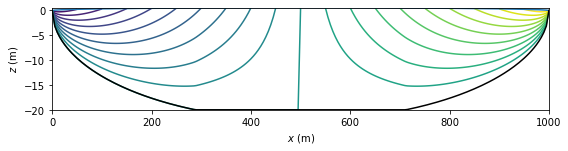

In [9]:
# basic streamline plot
plt.subplot(111, aspect=10)
plt.contour(xg, zg, psi, np.arange(-1, 1, 0.1))
plt.plot(x, h2, 'C0')
plt.plot(x, zi2, 'k')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()

## Combined confined/semi-confined interface flow

<img src="figs/fig4.3.png" width=400>

In [10]:
# parameters
k = 10 # hydraulic conductivity, m/d
zt = -10 # top of aquifer, m
zb = -30 # bottom of aquifer, m
alpha = 40 # alpha factor, -
clist = [1e-12, 5, 50] # three values of resistance of leaky layer, d
U = 0.4 # flow towards the coast, m^2/d
H = zt - zb # aquifer thickness, m

In [11]:
# solution
def interface(k, zt, zb, c, alpha, U):
    H = zt - zb
    # below sea
    hstar = -zt / alpha
    xtip = (18 * U * k * alpha * c**2) ** (1 / 3)
    xsea = np.linspace(0, xtip, 100)
    hsea = hstar + (xsea - xtip)**2 / (6 * k * alpha * c)
    h0 = hstar + xtip ** 2 / (6 * k * alpha * c)
    # below land
    phi0 = 0.5 * k * alpha * (h0 - hstar)**2
    phitoe = 0.5 * k * H ** 2 / alpha
    xtoe = -(phitoe - phi0) / U
    Cc = (0.5 * k * H ** 2 + k * H * zb) / alpha
    xland = np.linspace(xtoe, 0, 100)
    phi = -U * xland + phi0
    hland = np.sqrt(2 * phi/ (k * alpha)) + hstar
    # combine solution
    x = np.hstack((xland, xsea))
    zi = -alpha * np.hstack((hland, hsea))
    return x, zi

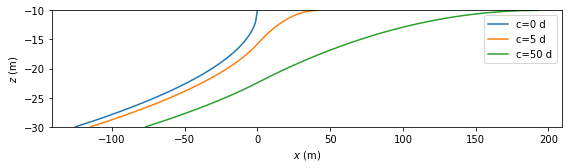

In [12]:
# basic plot
plt.subplot(111, aspect=4, ylim=(-30, -10))
for c in clist:
    x, zi = interface(k=k, zt=zt, zb=zb, c=c, alpha=alpha, U=U)
    plt.plot(x, zi, label=f'c={c:.0f} d')
plt.legend()
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()

In [13]:
c = 5
x, zi = interface(k=k, zt=zt, zb=zb, c=5, alpha=alpha, U=U)
x = np.hstack((-200, x))
zi = np.hstack((zb, zi))
Qx = U * np.ones_like(x)
lab = np.sqrt(c * k * H)
xtip = (18 * U * k * alpha * c**2) ** (1 / 3)
Qx[x>0] = -(x[x>0] - xtip) ** 3 / (18 * k * alpha * c**2)
xg = [x, x]
zg = [zi, zt * np.ones_like(x)]
psi = [np.zeros_like(x), Qx]

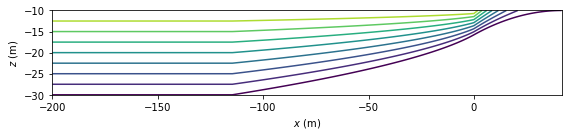

In [14]:
# basic streamline plot
plt.subplot(111, aspect=2)
plt.contour(xg, zg, psi)
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()